# Enjoy

In [1]:
import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [13]:
df = pdr.get_data_yahoo("AAPL", start="2020-01-01" , end = '2021-01-01').reset_index()

In [14]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [15]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/Users/yangtao/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 74.864998.3, cost: -19901.591797, total money: 10074.864998
epoch: 20, total rewards: 49.587490.3, cost: -21555.865234, total money: 10049.587490
epoch: 30, total rewards: 11.594994.3, cost: -22988.740234, total money: 10011.594994
epoch: 40, total rewards: 213.215008.3, cost: -24098.417969, total money: 10213.215008
epoch: 50, total rewards: 121.540020.3, cost: -25230.970703, total money: 10121.540020
epoch: 60, total rewards: 25.302509.3, cost: -26075.416016, total money: 10025.302509
epoch: 70, total rewards: 46.370007.3, cost: -26912.457031, total money: 10046.370007
epoch: 80, total rewards: 121.620022.3, cost: -27801.072266, total money: 10121.620022
epoch: 90, total rewards: 167.627525.3, cost: -28586.417969, total money: 10167.627525
epoch: 100, total rewards: 409.425018.3, cost: -28881.628906, total money: 10409.425018
epoch: 110, total rewards: 120.350052.3, cost: -29724.052734, total money: 10120.350052
epoch: 120, total rewards: 590.467552.3, cost:

In [16]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 77.582497, total balance 9922.417503
day 7, sell 1 unit at price 79.239998, investment 2.136437 %, total balance 10001.657501,
day 8: buy 1 unit at price 78.169998, total balance 9923.487503
day 9: buy 1 unit at price 77.834999, total balance 9845.652504
day 13: buy 1 unit at price 79.425003, total balance 9766.227501
day 15: buy 1 unit at price 79.577499, total balance 9686.650002
day 17, sell 1 unit at price 79.422501, investment 1.602280 %, total balance 9766.072502,
day 19, sell 1 unit at price 80.967499, investment 4.024539 %, total balance 9847.040001,
day 20, sell 1 unit at price 77.377502, investment -2.577904 %, total balance 9924.417503,
day 22, sell 1 unit at price 79.712502, investment 0.169649 %, total balance 10004.130005,
day 25: buy 1 unit at price 80.007500, total balance 9924.122505
day 26: buy 1 unit at price 80.387497, total balance 9843.735008
day 27: buy 1 unit at price 79.902496, total balance 9763.832512
day 28: buy 1 unit at price 81.

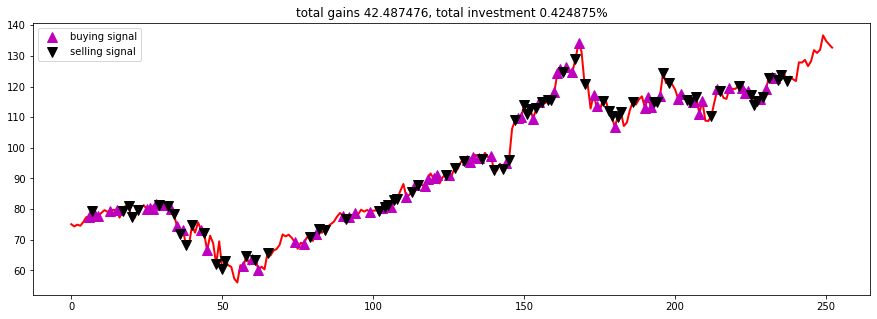

In [17]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()